# Clustering Cihan

In [1]:
import pandas as pd 
import numpy as np     
import matplotlib.pyplot as plt
import seaborn as sns

fragmenten_df = pd.read_csv('Data/fragments_data.csv')
birchFragmenten_df = fragmenten_df.copy()
birchFragmenten_df.head()

,fragment,labels,label_numeric
0,05190.100417.watersniproepEempolder_fragment_0...,watersnip,0
1,05190.100417.watersniproepEempolder_fragment_1...,watersnip,0
2,05190.100417.watersniproepEempolder_fragment_2...,watersnip,0
3,05190.100417.watersniproepEempolder_fragment_3...,watersnip,0
4,05190.100417.watersniproepEempolder_fragment_4...,watersnip,0


In [2]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(birchFragmenten_df, test_size=0.3, random_state=42)
test_data.head()

,fragment,labels,label_numeric
948,XC466471-Redshank (2)_fragment_0.wav,tureluur,1
3036,XC749107-2022-09-14 2020 Oeverlopers_fragment_...,oeverloper,4
1960,XC590410-200918_0480_2257_Watersnip_fragment_1...,watersnip,0
3543,XC834752-01.-1950-2050-watersnip_fragment_5.wav,watersnip,0
1689,"XC561755-Oeverloper, flight call, IGS, 050520,...",oeverloper,4


In [3]:
label_counts = test_data['labels'].value_counts()
print(label_counts)

labels
tureluur                  362
oeverloper                256
witgat                    202
watersnip                 170
zwarte ruiter             149
geelpootruiter             11
grauwe franjepoot          10
steenloper                  7
steltloper                  3
amerikaanse oeverloper      1
Name: count, dtype: int64


In [4]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd
from scipy.signal import stft
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler



for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    


c:\Users\Remzi\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Remzi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Remzi\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [5]:
# Initialize the features and filenames lists
features = []
filenames = []

for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    _, _, Zxx = stft(y, sr, nperseg=1024)
    stft_mean = np.mean(np.abs(Zxx))

    stft_librosa = librosa.stft(y, n_fft=1024, hop_length=512)
    stft_librosa_mean = np.mean(np.abs(stft_librosa))

    feature_vector = np.concatenate([mfcc_mean, [stft_mean], [stft_librosa_mean]])
    features.append(feature_vector)
    filenames.append(fragment)

features = np.array(features)

scaler = StandardScaler()
features = scaler.fit_transform(features)

distance_matrix = squareform(pdist(features, metric='euclidean'))


c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1083
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=369
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 1024 is greater than input length  = 369, using nperseg = 369
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=369
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=645
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 1024 is greater than input l

In [6]:
from sklearn.manifold import TSNE

# Ensure features array is valid before applying t-SNE
if np.isnan(features).any() or np.isinf(features).any():
    print("Error: Features array contains NaN or infinite values. Please check your data.")
else:
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

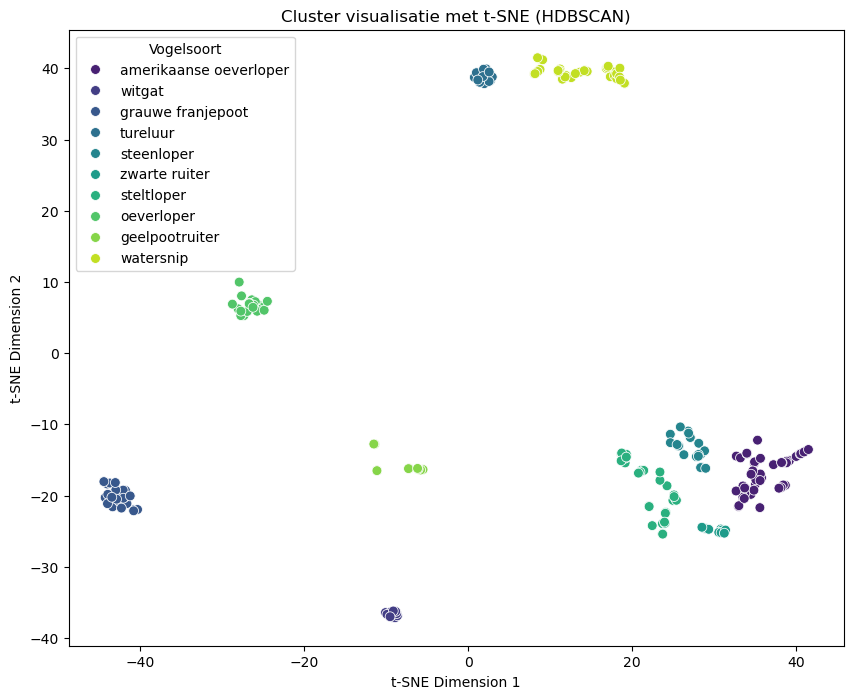

In [14]:
import hdbscan

# HDBSCAN clustering toepassen
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
hdbscan_labels = hdbscan_clusterer.fit_predict(features_tsne)

# Maakt een lijst van fragmenten en hun HDBSCAN-clusterlabels
fragmenten_clusters = list(enumerate(hdbscan_labels))

#de labels worden toegevoegd aan de clusters
species_labels_hdbscan = [
    test_data.loc[test_data['label_numeric'] == label, 'labels'].iloc[0]
    if label in test_data['label_numeric'].values else 'Onbekend'
    for label in hdbscan_labels
]

# Filteren om onbekende labels te verwijderen
filtered_indices_hdbscan = [i for i, label in enumerate(species_labels_hdbscan) if label != 'Onbekend']
filtered_features_tsne_hdbscan = features_tsne[filtered_indices_hdbscan]
filtered_species_labels_hdbscan = [species_labels_hdbscan[i] for i in filtered_indices_hdbscan]

# Cluster visualisatie met t-SNE en HDBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x=filtered_features_tsne_hdbscan[:, 0], y=filtered_features_tsne_hdbscan[:, 1], hue=filtered_species_labels_hdbscan, palette='viridis', s=50)
plt.title("Cluster visualisatie met t-SNE (HDBSCAN)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Vogelsoort", loc='best')
plt.show()

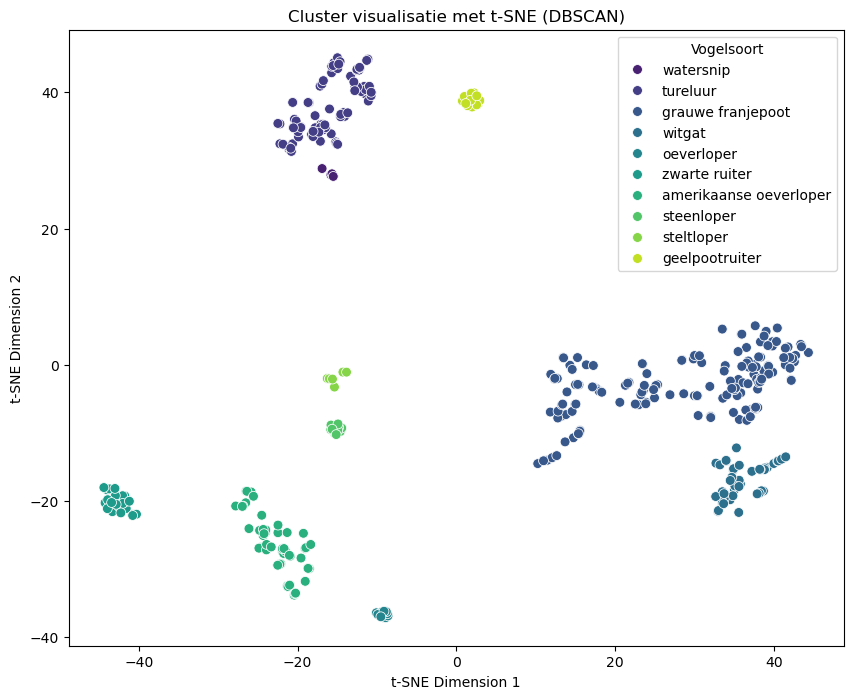

In [16]:
from sklearn.cluster import DBSCAN

# Pas DBSCAN toe op de t-SNE features
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_tsne)

#de labels worden toegevoegd aan de de clusters
species_labels_dbscan = [
    test_data.loc[test_data['label_numeric'] == label, 'labels'].iloc[0]
    if label in test_data['label_numeric'].values else 'Onbekend'
    for label in dbscan_labels
]

# Filter de gegevens om "Onbekend" te verwijderen
filtered_indices_dbscan = [i for i, label in enumerate(species_labels_dbscan) if label != 'Onbekend']
filtered_features_tsne_dbscan = features_tsne[filtered_indices_dbscan]
filtered_species_labels_dbscan = [species_labels_dbscan[i] for i in filtered_indices_dbscan]

# Plot de clusters zonder "Onbekend"
plt.figure(figsize=(10, 8))
sns.scatterplot(x=filtered_features_tsne_dbscan[:, 0], y=filtered_features_tsne_dbscan[:, 1], hue=filtered_species_labels_dbscan, palette='viridis', s=50)
plt.title("Cluster visualisatie met t-SNE (DBSCAN)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Vogelsoort", loc='best')
plt.show()


# Voorspellend model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# features en labels maken
X = features
y = test_data['label_numeric']

# Train test maken
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random forest trainen met random state 42.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Voorspellingen maken
y_pred = rf.predict(X_test)

# Evaluatie
print("Accuracy:", accuracy_score(y_test, y_pred))

# unieke labels tonen
unique_labels = np.unique(y_test)
target_names = [fragmenten_df[fragmenten_df['label_numeric'] == label]['labels'].iloc[0] for label in unique_labels]

print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))

Accuracy: 0.7727272727272727
                        precision    recall  f1-score   support

             watersnip       0.71      0.82      0.76        44
              tureluur       0.87      0.90      0.88       122
     grauwe franjepoot       1.00      0.33      0.50         3
                witgat       0.64      0.72      0.68        53
            oeverloper       0.71      0.82      0.76        76
         zwarte ruiter       0.91      0.45      0.60        47
amerikaanse oeverloper       0.00      0.00      0.00         1
            steenloper       1.00      1.00      1.00         1
        geelpootruiter       1.00      0.60      0.75         5

              accuracy                           0.77       352
             macro avg       0.76      0.63      0.66       352
          weighted avg       0.79      0.77      0.77       352



c:\Users\Remzi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Remzi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Remzi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


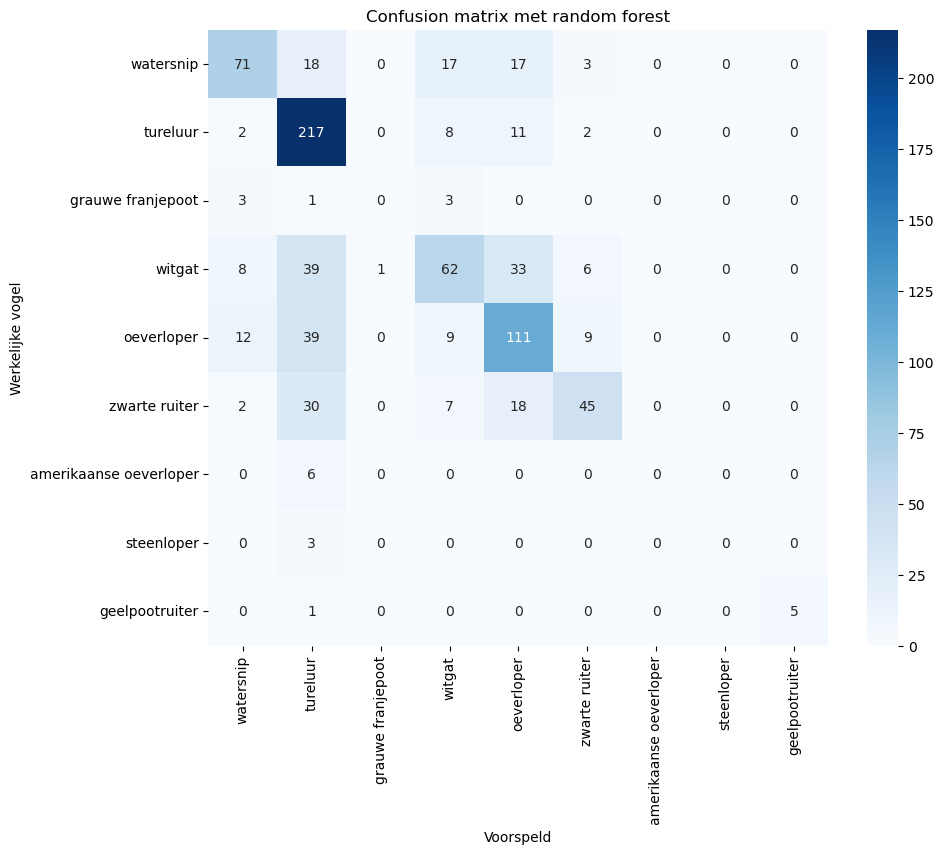

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Gebruik de features en labels van test_data
X = features
y = test_data['label_numeric']

# Train test split maken 70% test 30% train
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3, random_state=42)

# Random forest trainen met random state 42
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# voorspelling maken
y_pred = rf.predict(X_test)



# Tonenen heatmap confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Voorspeld')
plt.ylabel('Werkelijke vogel')
plt.title('Confusion matrix met random forest')
plt.show()



In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Gebruik de features en labels van test_data
X = features
y = test_data['label_numeric']

# Train test split maken 70% test 30% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Naive Bayes Classifier trainen
nb = GaussianNB()
nb.fit(X_train, y_train)

# Voorspellingen maken
y_pred = nb.predict(X_test)

# Evaluatie
print("Accuracy:", accuracy_score(y_test, y_pred))

# Labels tonen
unique_labels = np.unique(y_test)
target_names = [fragmenten_df[fragmenten_df['label_numeric'] == label]['labels'].iloc[0] for label in unique_labels]

print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))

Accuracy: 0.3835227272727273
                        precision    recall  f1-score   support

             watersnip       0.53      0.48      0.50        44
              tureluur       0.67      0.49      0.57       122
     grauwe franjepoot       0.07      0.67      0.13         3
                witgat       0.39      0.23      0.29        53
            oeverloper       0.58      0.24      0.34        76
         zwarte ruiter       0.13      0.36      0.20        47
amerikaanse oeverloper       0.00      0.00      0.00         1
            steenloper       1.00      1.00      1.00         1
        geelpootruiter       1.00      0.80      0.89         5

              accuracy                           0.38       352
             macro avg       0.48      0.47      0.43       352
          weighted avg       0.52      0.38      0.42       352



c:\Users\Remzi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Remzi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Remzi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


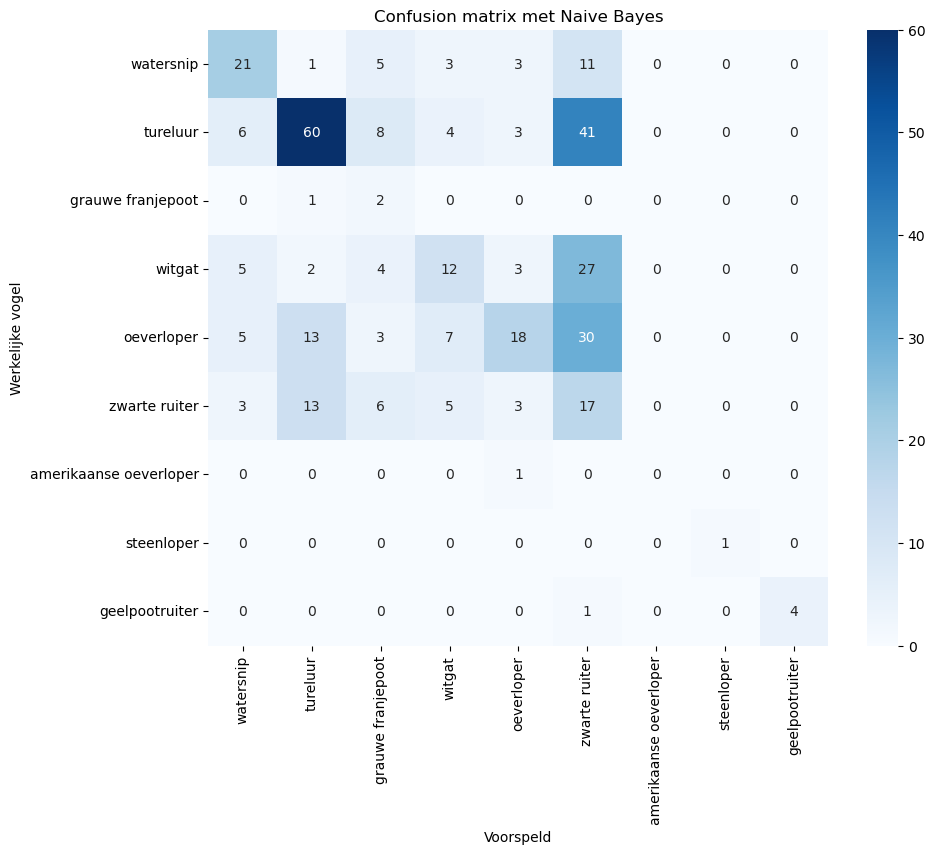

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

# features gebruiken van hierboven
X = features
y = test_data['label_numeric']

# train test split maken 70% test 30% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Naive Bayes Classifier trainen
nb = GaussianNB()
nb.fit(X_train, y_train)

# Voorspellen 
y_pred = nb.predict(X_test)

# Tonen heatmap confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Voorspeld')
plt.ylabel('Werkelijke vogel')
plt.title('Confusion matrix met Naive Bayes')
plt.show()

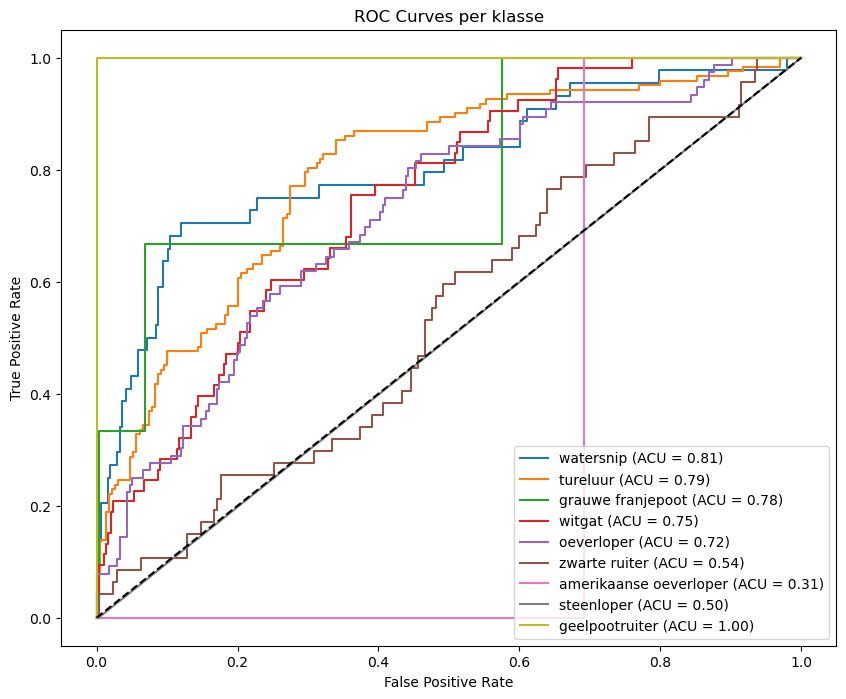

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# labels binarize voor ROC curve
y_test_bin = label_binarize(y_test, classes=unique_labels)
y_pred_prob = nb.predict_proba(X_test)

#tonen ROC curve
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (ACU = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per klasse')
plt.legend()
plt.show()
